In [218]:
from multilayer_perceptron import *

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from copy import deepcopy

np.random.seed(0)

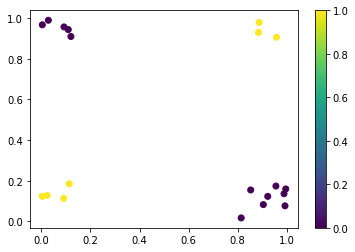

In [209]:
observations = 20
xs = (np.random.uniform(0, 0.2, observations*2) + np.random.choice([0, 0.8], observations*2)).reshape([observations, 2])
ys = (np.sign(xs - 0.5).prod(axis=1) + 1) / 2
plt.scatter(xs[:, 0], xs[:, 1], c=ys)
plt.colorbar();

Text(0.5, 0, 'iteration')

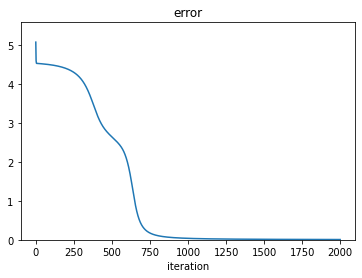

In [214]:
mlp = MultiLayerPerceptron(2, [3, 3, 1], node_type=NodeLogistic, learning_rate=0.1)

errors = []
intermediate_mlps = []

for _ in range(2000):
    intermediate_mlps.append(deepcopy(mlp))
    for i in range(len(xs)):
        mlp.backward(xs[i], ys[i])
    errors.append(sum([mlp.error(xs[i], ys[i]) for i in range(len(xs))]))

plt.plot(errors)
plt.ylim(0, max(errors) * 1.1)
plt.title('Error')
plt.xlabel('iteration')

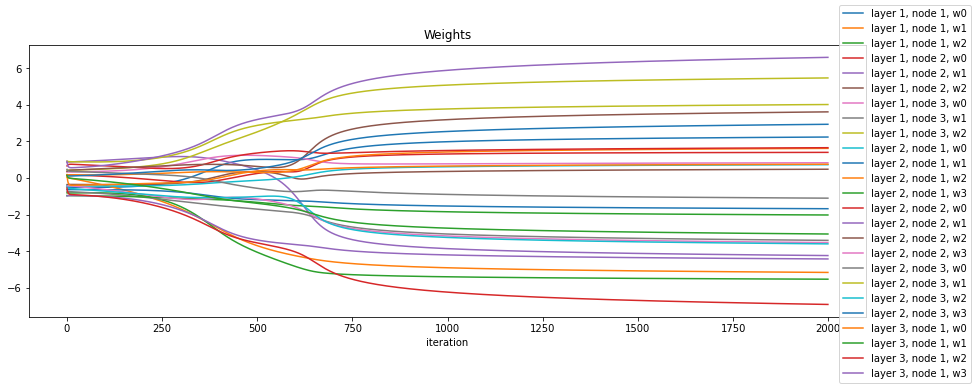

In [215]:
f, ax = plt.subplots(figsize=(15, 5))

for layer in range(len(mlp.layers)):
    for j in range(len(mlp.layers[layer])):
        for i in range(len(mlp.layers[layer][j].w)):
            weights = [m.layers[layer][j].w[i] for m in intermediate_mlps]
            ax.plot(weights, label=f'layer {layer + 1}, node {j + 1}, w{i}')
ax.set_title('Weights')
ax.set_xlabel('iteration')
f.legend();

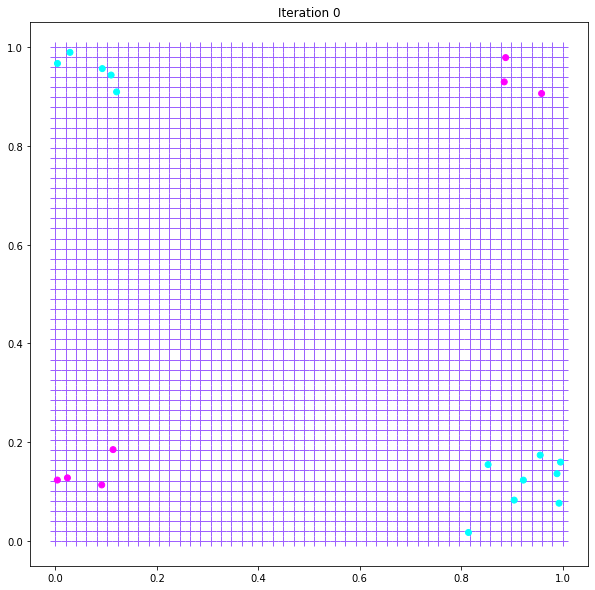

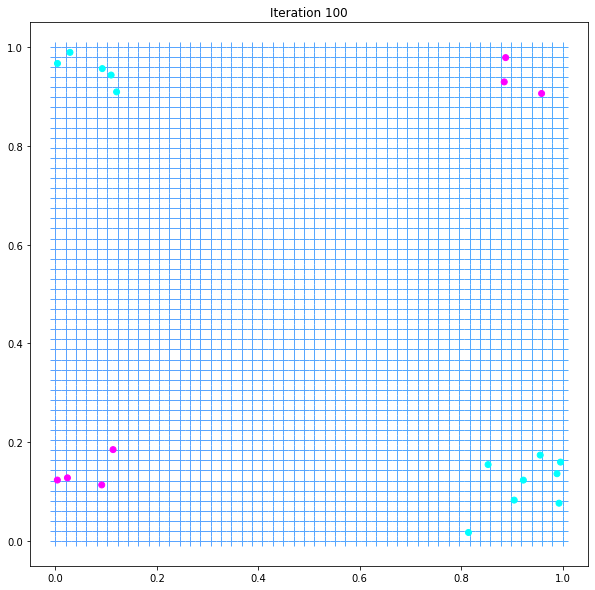

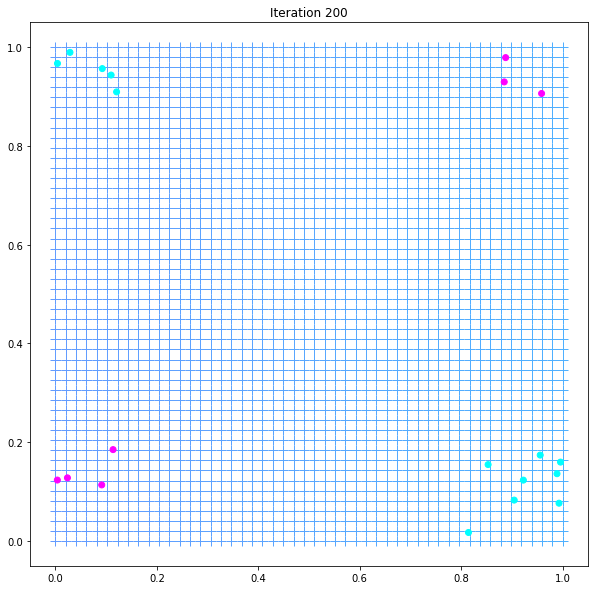

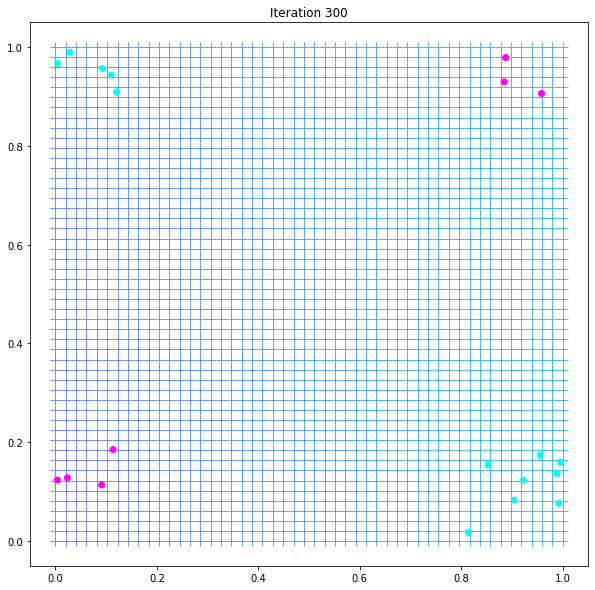

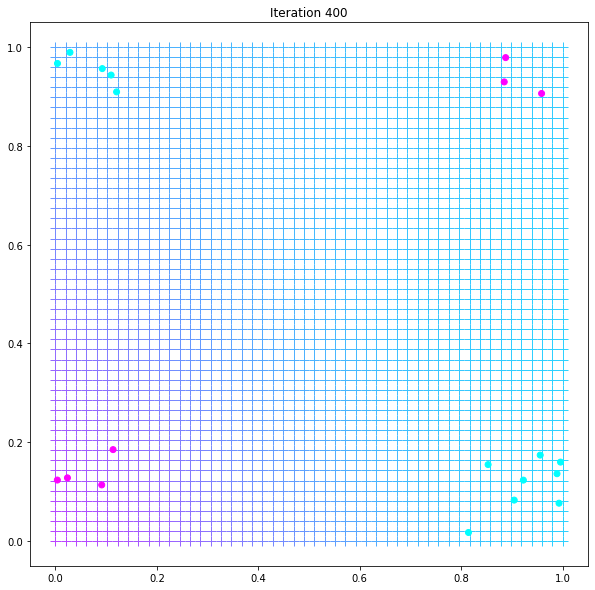

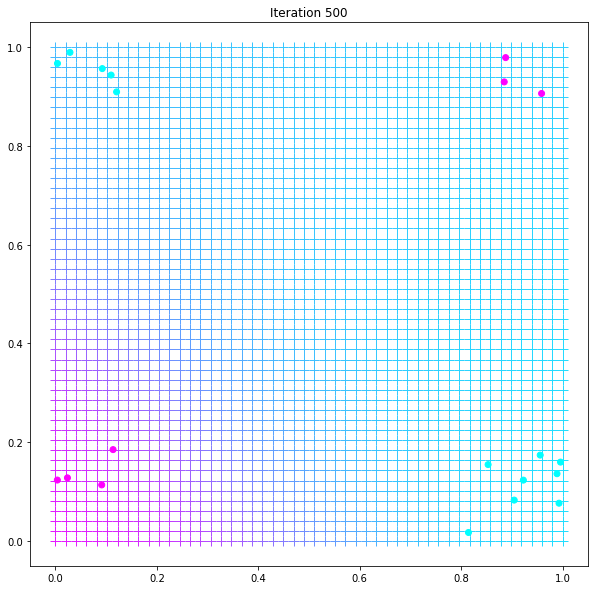

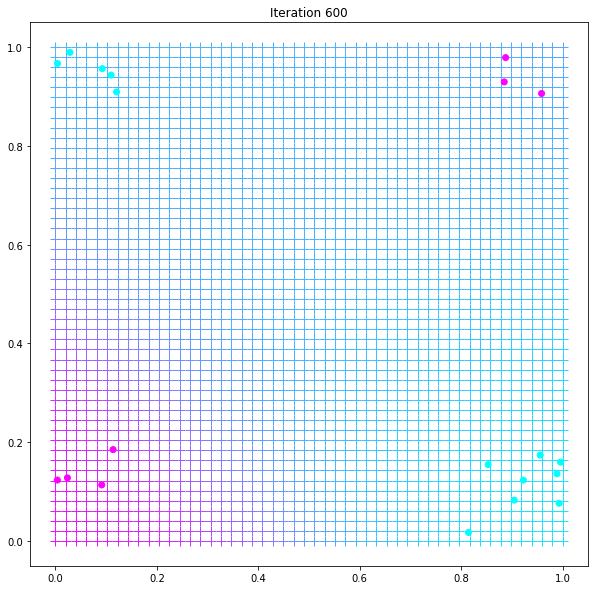

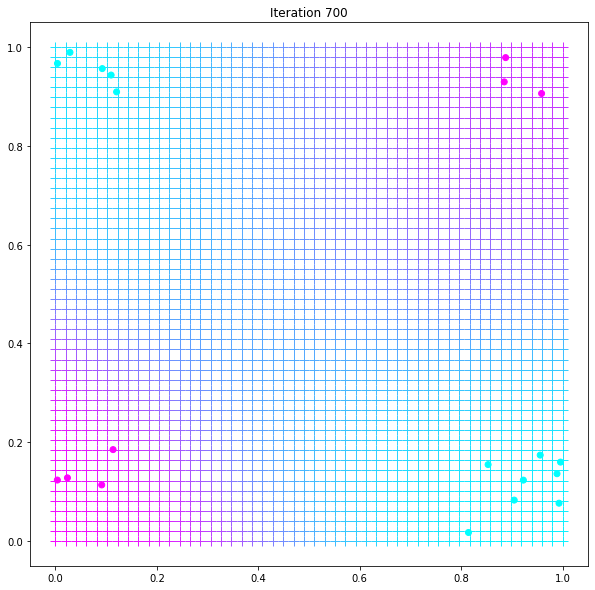

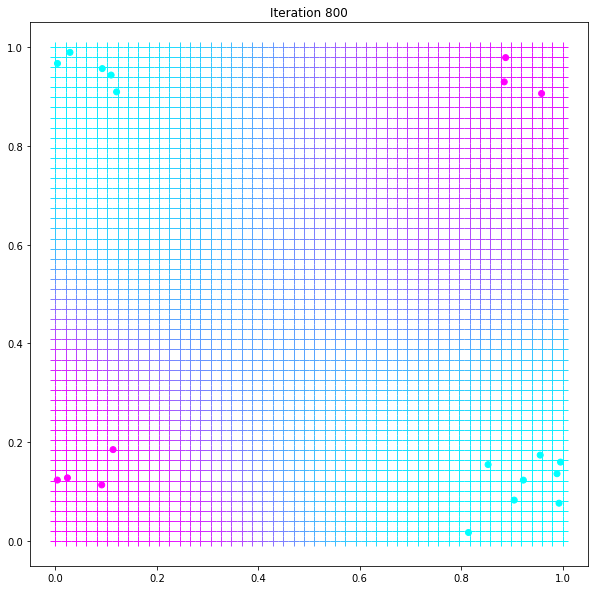

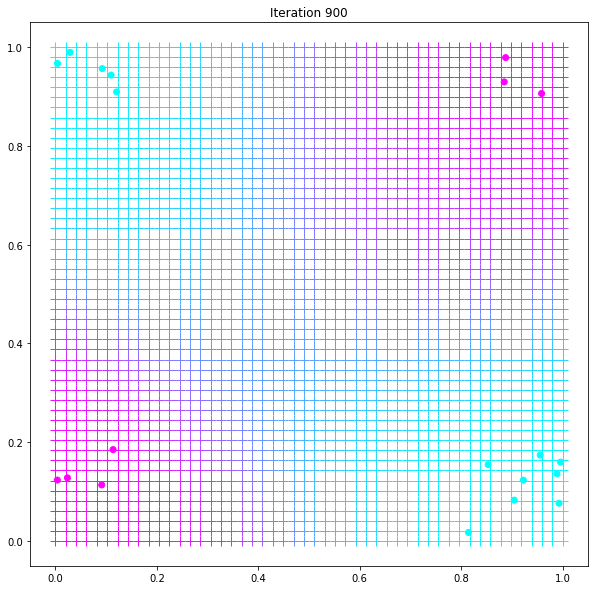

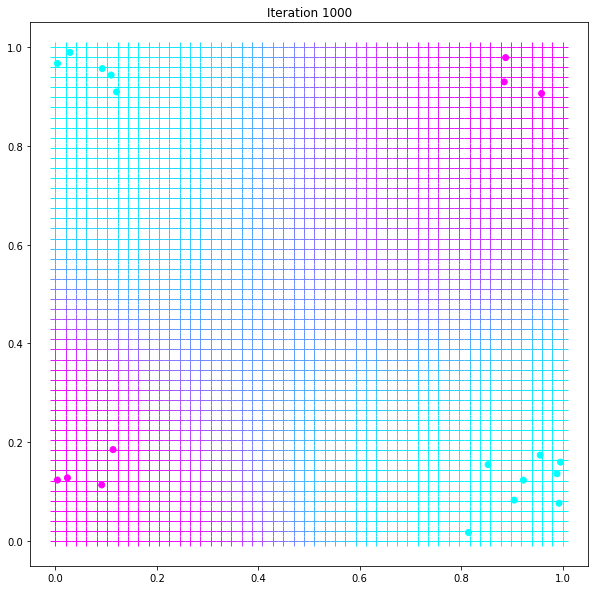

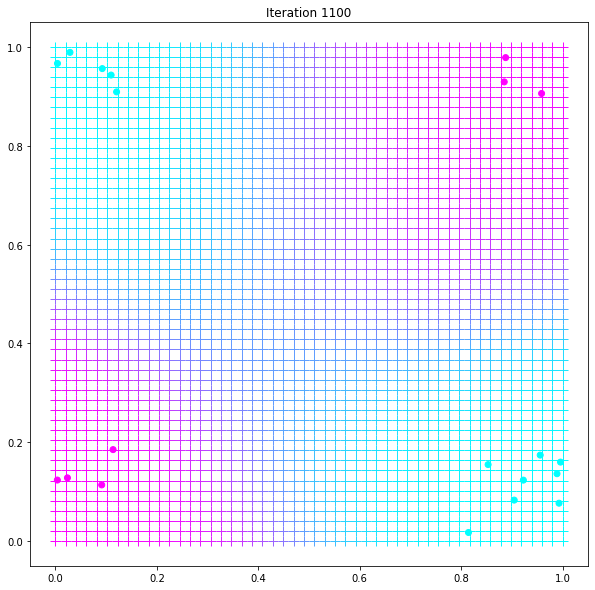

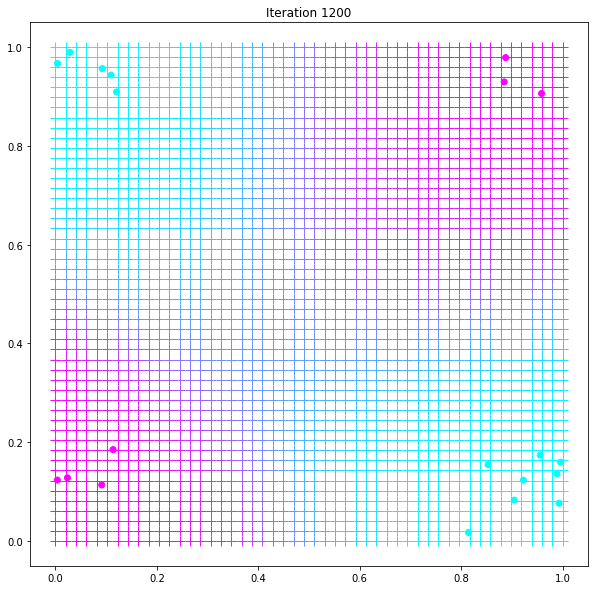

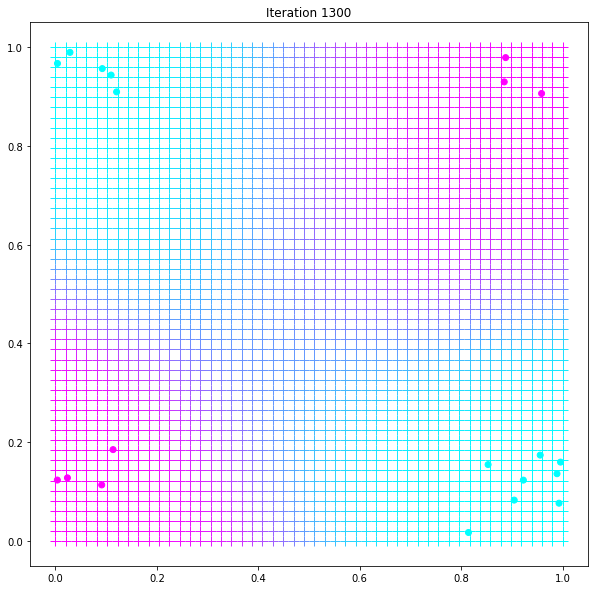

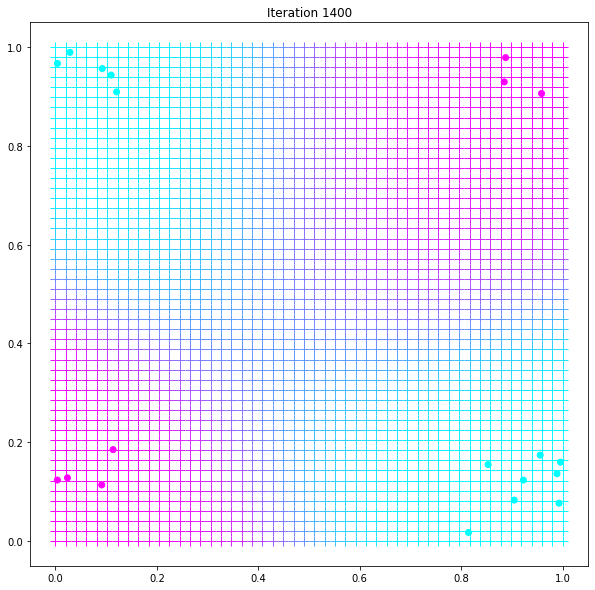

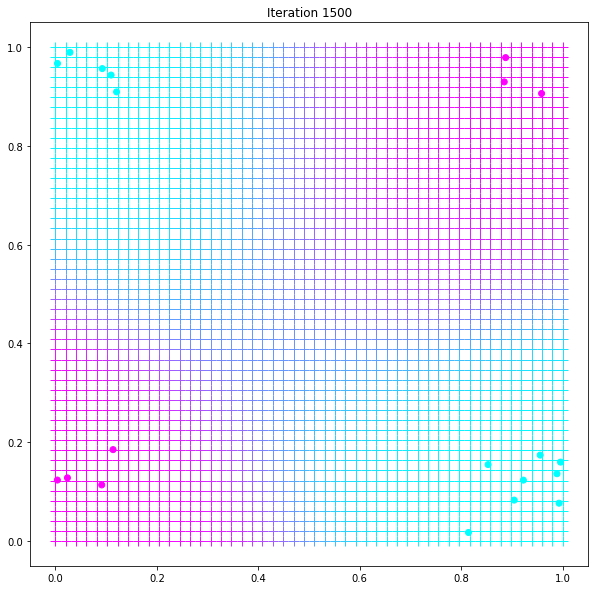

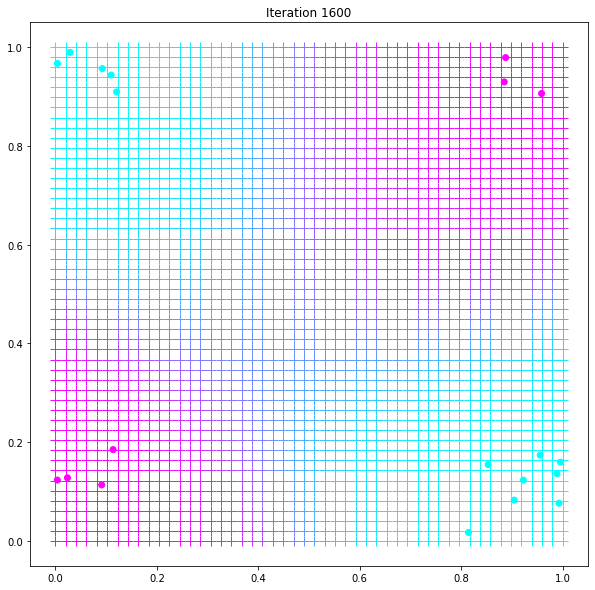

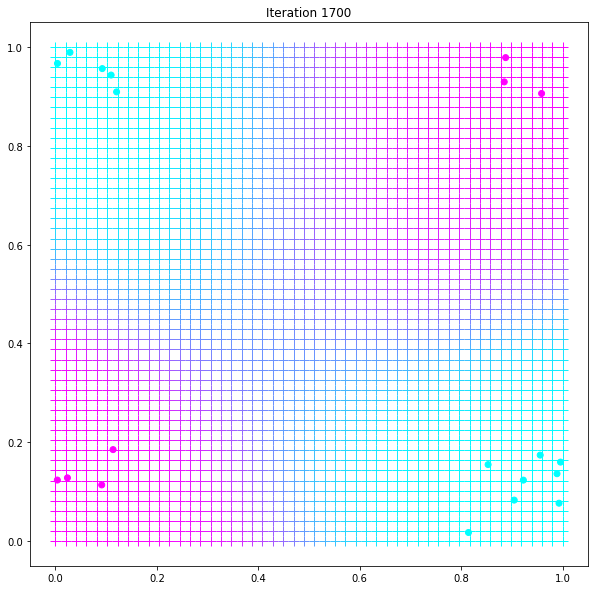

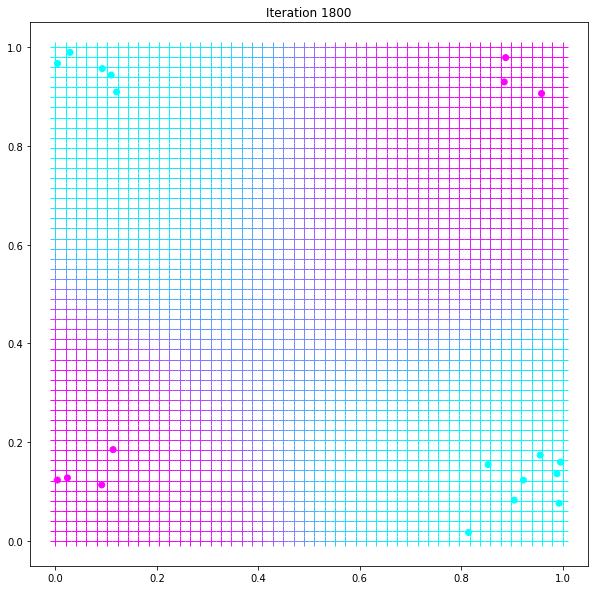

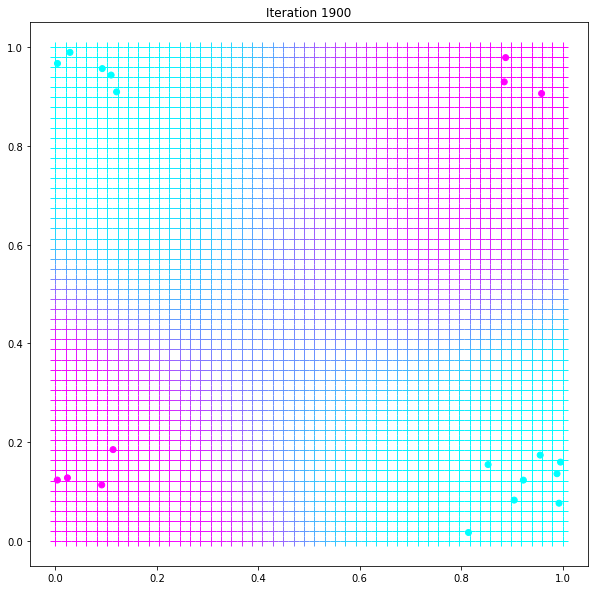

In [216]:
for i, mlp in enumerate(intermediate_mlps):
    if i % 100 != 0:
        continue
    
    fig, ax = plt.subplots(figsize=(10, 10))

    xs_test = np.array(list(product(np.linspace(0, 1, 50), np.linspace(0, 1, 50))))
    ys_test = [mlp(x) for x in xs_test]

    ax.scatter(xs_test[:, 0], xs_test[:, 1], c=ys_test, cmap='cool', marker='+', s=110, linewidths=1, vmin=0, vmax=1)

    ax.scatter(x=xs[:, 0], y=xs[:, 1], c=ys, cmap='cool', vmin=0, vmax=1)
    ax.set_title(f'Iteration {i}')
    plt.show()

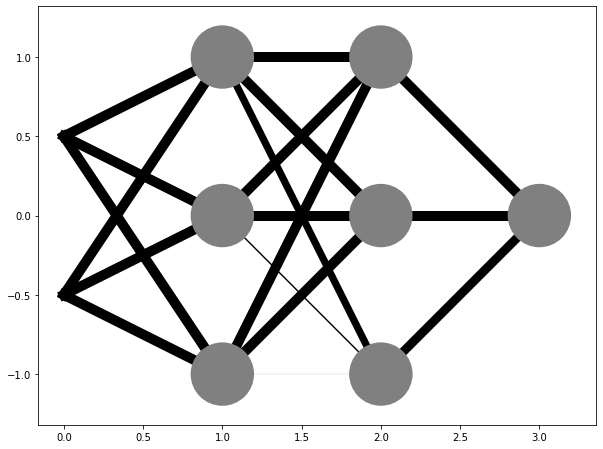

In [213]:
mlp.plot()